In [1]:
import os
import numpy as np
import tensorflow as tf
#import data as d
#import model
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb

/home/nextgen/anaconda3/envs/tf/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [16]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [15]:
sess=tf.compat.v1.Session()
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256

In [8]:
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

IndexPrice shape:  (5328, 1)


ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by MinMaxScaler.

In [28]:
kospi=StockData(
    'NASDAQ/Sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

IndexPrice shape:  (40559, 1)


ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by MinMaxScaler.

In [3]:

rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state


class Attention_Layer():
    """
    어텐션 레이어.
    (None, TimeWindow, hidden_unit_size) shape의 LSTM 출력을 입력으로 받아 (None, 1, hidden_unit_size)의 텐서 출력.
    
    """
    def __init__(
        self,
        timewindow_size,
        input_hidden_unit_size,
        attention_size=None):
        """
        Setting parameter for attention layer.
        args:
            timewindow_size = time window size of previous lstm layer.
            input_hidden_unit_size = hidden unit number of previous lstm layer.
            attention_size = size of this attention. 
                default = input_hidden_unit_size.
        """
        if(attention_size is None):
            attention_size=input_hidden_unit_size
        self.o_size=attention_size
        self.h_size=input_hidden_unit_size
        self.t_size=timewindow_size

        self.beta_weight=tf.Variable(tf.random.normal([self.h_size,self.o_size]), name='beta_weight')
        self.beta_bias=tf.Variable(tf.zeros([self.o_size]),name='beta_bias')

        self.v=tf.Variable(tf.random.normal([self.o_size,1]),name='beta_v')

    def __call__(self,inputs):
        """
        producing output with actual inputs.
        shape of output will be (batch_size, 1, input_hidden_unit_size).
        """
        #temp = tanh(Y X W + b) ->shape of result = (-1, self.o_size)
        temp=tf.matmul(tf.reshape(inputs,[-1,self.h_size]),self.beta_weight)
         
        temp=tf.tanh(temp+self.beta_bias)
        
            
        #j=temp X v
        j=tf.reshape(tf.matmul(temp,self.v),[-1,self.t_size,1])

        beta=tf.nn.softmax(j)
        
        

        output=beta*inputs
        return output



In [4]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
       

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
       
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
       

        #Attention_Layer
        attention_layer=Attention_Layer(self.T,64)
        
        Y_3=attention_layer(Y_2)
        

        #Non-linear units for producing final prediction.
        R_1=tf.compat.v1.layers.dense(tf.compat.v1.layers.flatten(Y_3),64,tf.nn.relu)
        
        R_2=tf.compat.v1.layers.dense(R_1,64,tf.nn.relu)
        
        R_3=tf.compat.v1.layers.dense(R_2,64,tf.nn.relu)
        
        R_4=tf.compat.v1.layers.dense(R_3,64,tf.nn.relu)
        
        R_5=tf.compat.v1.layers.dense(R_4,64,tf.nn.relu)
        
        R_6=tf.compat.v1.layers.dense(R_5,1)
       
        self.out=R_6
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)

    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

## date_duration=3000 & NASDAQ data사용 & epoch=100 & batch_size=256

In [11]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  5.237458671443164
evalution_cost :  0.3748883716762066
epoch : 0, t_cost : 0.050360, e_cost : 0.008520, elapsed time : 20.50sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  1.1653711509425193
evalution_cost :  0.2531801275908947
epoch : 1, t_cost : 0.011205, e_cost : 0.005754, elapsed time : 14.74sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.7974493517540395
evalution_cost :  0.3047790043056011
epoc

In [18]:
np.shape(kospi.trainSet)

(53690,)

In [17]:
np.shape(kospi.testSet)

(23010,)

## data_duration=40560 & NASDAQ data 사용 & epoch=100 & batch_size=256

In [31]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256
#

print('\n#training#')
kospi=StockData(
    'NASDAQ/Sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))


#training#
IndexPrice shape:  (40559, 1)
StockPrice shape:  (40559, 81)
making dataset progress : finished	59
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  8.41795479972643
evalution_cost :  568.7187625253828
epoch : 0, t_cost : 0.000938, e_cost : 0.147911, elapsed time : 1224.36sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  2.104333292263618
evalution_cost :  303.60862822203853
epoch : 1, t_cost : 0.000235, e_cost : 0.078962, elapsed time : 1219.76sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  1.75218784

data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  1.0204778575462115
evalution_cost :  168.43559724850093
epoch : 24, t_cost : 0.000114, e_cost : 0.043806, elapsed time : 1220.16sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  1.0234521317802319
evalution_cost :  168.79209531523884
epoch : 25, t_cost : 0.000114, e_cost : 0.043899, elapsed time : 1219.84sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  1.005651818500155
evalution_cost :  167.1788903430006
epoch : 26, t_cost : 0.000112, e_cost : 0.043480, elapsed tim

data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.9281553460182295
evalution_cost :  172.59171290512677
epoch : 48, t_cost : 0.000103, e_cost : 0.044887, elapsed time : 1219.70sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.8978304833362927
evalution_cost :  174.8418985025146
epoch : 49, t_cost : 0.000100, e_cost : 0.045473, elapsed time : 1219.90sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.9194726915161482
evalution_cost :  176.87693804361334
epoch : 50, t_cost : 0.000102, e_cost : 0.046002, elapsed time : 1219.65sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 

traning_cost :  0.8311184860554022
evalution_cost :  156.7732402355632
epoch : 72, t_cost : 0.000093, e_cost : 0.040773, elapsed time : 1219.59sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.8383389254836402
evalution_cost :  154.85801175663255
epoch : 73, t_cost : 0.000093, e_cost : 0.040275, elapsed time : 1219.78sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.8242161296493578
evalution_cost :  155.52892991053886
epoch : 74, t_cost : 0.000092, e_cost : 0.040450, elapsed time : 1219.91sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16,

data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.8236596775591352
evalution_cost :  156.52510166694083
epoch : 97, t_cost : 0.000092, e_cost : 0.040709, elapsed time : 1220.08sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.8179765247923569
evalution_cost :  157.9454544334476
epoch : 98, t_cost : 0.000091, e_cost : 0.041078, elapsed time : 1220.03sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.8216185518322163
evalution_cost :  158.0398802705622
epoch : 99, t_cost : 0.000092, e_cost : 0.041103, elapsed tim

## eopch : 10 , batchsize : 512 , timesize : 4

In [5]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
data1 :  (53690, 4, 1) (53690, 10, 4, 1) (53690, 10, 4, 1) (53690, 4, 1) (53

## eopch : 30 , batchsize : 512 , timesize : 16

In [6]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(30):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  4.397981100715697
evalution_cost :  0.29077428951859474
epoch : 0, t_cost : 0.042288, e_cost : 0.006609, elapsed time : 19.31sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.8660098274704069
evalution_cost :  0.3474391414783895
epoch : 1, t_cost : 0.008327, e_cost : 0.007896, elapsed time : 14.31sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.8573140774387866
evalution_cost :  0.3989060885505751
epo

data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.21721531567163765
evalution_cost :  0.08275402092840523
epoch : 25, t_cost : 0.002089, e_cost : 0.001881, elapsed time : 14.43sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.21648004226153716
evalution_cost :  0.08283119078259915
epoch : 26, t_cost : 0.002082, e_cost : 0.001883, elapsed time : 14.35sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.2185226451838389
evalution_cost :  0.08572887562331744
epoch : 27, t_cost : 0.002101, e_cost : 0.001948, elapsed time : 14.49sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (2301

## eopch : 100 , batchsize : 256 , timesize : 8

In [7]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=8
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  7.292597506660968
evalution_cost :  0.3700101098511368
epoch : 0, t_cost : 0.034893, e_cost : 0.004157, elapsed time : 19.99sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  1.1710608782013878
evalution_cost :  0.5209772535599768
epoch : 1, t_cost : 0.005603, e_cost : 0.005854, elapsed time : 15.04sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  1.2526973487110808
evalution_cost :  0.6881660227663815
epoch : 2, t_cost : 0.005994

data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.3388351756730117
evalution_cost :  0.13254845290794037
epoch : 26, t_cost : 0.001621, e_cost : 0.001489, elapsed time : 15.02sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.3361312987108249
evalution_cost :  0.13135324316681363
epoch : 27, t_cost : 0.001608, e_cost : 0.001476, elapsed time : 15.04sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.33205106362584047
evalution_cost :  0.13021673006005585
epoch : 28, t_cost : 0.001589, e_cost : 0.001463, elapsed time : 15.03sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8

traning_cost :  0.30129198177019134
evalution_cost :  0.10217295071925037
epoch : 52, t_cost : 0.001442, e_cost : 0.001148, elapsed time : 15.04sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.29878516669850796
evalution_cost :  0.10211376714869402
epoch : 53, t_cost : 0.001430, e_cost : 0.001147, elapsed time : 15.04sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.2980701925116591
evalution_cost :  0.10227026368374936
epoch : 54, t_cost : 0.001426, e_cost : 0.001149, elapsed time : 15.03sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.29695893698954023
evalution_cost : 

traning_cost :  0.2803121214383282
evalution_cost :  0.09700144320959225
epoch : 78, t_cost : 0.001341, e_cost : 0.001090, elapsed time : 15.05sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.27680695822346024
evalution_cost :  0.09620141561026685
epoch : 79, t_cost : 0.001324, e_cost : 0.001081, elapsed time : 15.05sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.27325359656242654
evalution_cost :  0.09713814599672332
epoch : 80, t_cost : 0.001307, e_cost : 0.001091, elapsed time : 15.03sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.2784076761745382
evalution_cost :  

## eopch : 100 , batchsize : 512 , timesize : 8

In [5]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=8
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53

data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.30370877333916724
evalution_cost :  0.09182775270892307
epoch : 17, t_cost : 0.002920, e_cost : 0.002087, elapsed time : 7.35sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.2915881389635615
evalution_cost :  0.08696647151373327
epoch : 18, t_cost : 0.002804, e_cost : 0.001977, elapsed time : 7.34sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.28197835735045373
evalution_cost :  0.0888836164958775
epoch : 19, t_cost : 0.002711, e_cost : 0.002020, elapsed time : 7.34sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1

traning_cost :  0.20747731201117858
evalution_cost :  0.06766320980386809
epoch : 43, t_cost : 0.001995, e_cost : 0.001538, elapsed time : 7.35sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.21165378001751378
evalution_cost :  0.06808021507458761
epoch : 44, t_cost : 0.002035, e_cost : 0.001547, elapsed time : 7.35sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.2193387860315852
evalution_cost :  0.06952744704904035
epoch : 45, t_cost : 0.002109, e_cost : 0.001580, elapsed time : 7.34sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.23439424368552864
evalution_cost :  0.

data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.21831519162515178
evalution_cost :  0.050655779778026044
epoch : 70, t_cost : 0.002099, e_cost : 0.001151, elapsed time : 7.35sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.21981365123065189
evalution_cost :  0.05123206117423251
epoch : 71, t_cost : 0.002114, e_cost : 0.001164, elapsed time : 7.35sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.2235554859507829
evalution_cost :  0.052158753911498934
epoch : 72, t_cost : 0.002150, e_cost : 0.001185, elapsed time : 7.34sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8

traning_cost :  0.19977687776554376
evalution_cost :  0.05531679274281487
epoch : 96, t_cost : 0.001921, e_cost : 0.001257, elapsed time : 7.34sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.21153832011623308
evalution_cost :  0.05470294185215607
epoch : 97, t_cost : 0.002034, e_cost : 0.001243, elapsed time : 7.33sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.19434519647620618
evalution_cost :  0.05514282686635852
epoch : 98, t_cost : 0.001869, e_cost : 0.001253, elapsed time : 7.34sec
data1 :  (53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
data1 :  (23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
traning_cost :  0.19813650043215603
evalution_cost :  0

In [29]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'NASDAQ/Sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size) 

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}

for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (40559, 1)


ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by MinMaxScaler.

In [5]:
import matplotlib.pyplot as plt

## eopch : 100 , batchsize : 512 , timesize : 16

IndexPrice shape:  (40559, 1)
StockPrice shape:  (40559, 81)
making dataset progress : finished	59

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10

data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.5411523033990306
evalution_cost :  45.5814146118737
epoch : 16, t_cost : 0.000121, e_cost : 0.023716, elapsed time : 938.24sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.5366175952221965
evalution_cost :  43.75581144885291
epoch : 17, t_cost : 0.000120, e_cost : 0.022766, elapsed time : 938.26sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.5244766067489763
evalution_cost :  42.13528471648533
epoch : 18, t_cost : 0.000117, e_cost : 0.021923, elapsed time : 939.02sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (22

data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.40562980028425955
evalution_cost :  30.819143404525676
epoch : 41, t_cost : 0.000090, e_cost : 0.016035, elapsed time : 944.07sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.3992421262537391
evalution_cost :  31.239323041647367
epoch : 42, t_cost : 0.000089, e_cost : 0.016254, elapsed time : 948.28sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.39750015563549823
evalution_cost :  32.83285181240353
epoch : 43, t_cost : 0.000089, e_cost : 0.017083, elapsed ti

data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.3680208458481502
evalution_cost :  28.650527871843224
epoch : 65, t_cost : 0.000082, e_cost : 0.014907, elapsed time : 941.72sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.36694298398106184
evalution_cost :  27.504465872434594
epoch : 66, t_cost : 0.000082, e_cost : 0.014310, elapsed time : 942.06sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.3662334145656132
evalution_cost :  28.608262596757413
epoch : 67, t_cost : 0.000082, e_cost : 0.014885, elapsed time : 943.41sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1

traning_cost :  0.34848637016557404
evalution_cost :  25.245317456876364
epoch : 89, t_cost : 0.000078, e_cost : 0.013135, elapsed time : 942.11sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.3510448431034092
evalution_cost :  24.55422373903457
epoch : 90, t_cost : 0.000078, e_cost : 0.012775, elapsed time : 948.60sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
traning_cost :  0.34728315611482685
evalution_cost :  24.900901185228577
epoch : 91, t_cost : 0.000077, e_cost : 0.012956, elapsed time : 949.47sec
data1 :  (2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
data1 :  (984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 

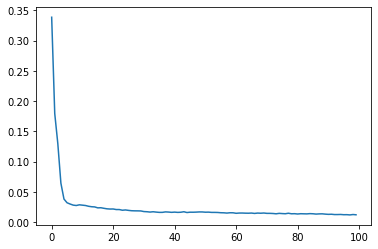

In [6]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'DARNNdata/NASDAQ',
    'DARNNdata/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt2=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    evalution_costplt2.append(evalution_cost)
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
plt.plot(evalution_costplt2)

## epoch : 100 , batchsize : 512 , timesize : 16
## timesize_for_calc_correlation=100
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  5.93792120879516
evalution_cost :  0.34546382108237594
epoch : 0, t_cost : 0.057095, e_cost : 0.007851, elapsed time : 26.29sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  1.122515910770744
evalution_cost :  0.29940168443135917
epoch : 1, t_cost : 0.010793, e_cost : 0.006805, elapsed time : 21.74sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.90451978915371
evalution_cost :  0.30890198750421405
epoch

data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.21598666987847537
evalution_cost :  0.08136032742913812
epoch : 25, t_cost : 0.002077, e_cost : 0.001849, elapsed time : 21.78sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.21193036035401747
evalution_cost :  0.08174653112655506
epoch : 26, t_cost : 0.002038, e_cost : 0.001858, elapsed time : 21.81sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.20607261161785573
evalution_cost :  0.07386284647509456
epoch : 27, t_cost : 0.001981, e_cost : 0.001679, elapsed time : 21.79sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (230

data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.15056030068080872
evalution_cost :  0.04778144205920398
epoch : 51, t_cost : 0.001448, e_cost : 0.001086, elapsed time : 21.79sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.1501336062210612
evalution_cost :  0.0479630644840654
epoch : 52, t_cost : 0.001444, e_cost : 0.001090, elapsed time : 21.79sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.14981864433502778
evalution_cost :  0.0478867242927663
epoch : 53, t_cost : 0.001441, e_cost : 0.001088, elapsed time : 21.78sec
data1 :  (53690, 16, 1) (53690,

traning_cost :  0.14458400604780763
evalution_cost :  0.0661278368497733
epoch : 76, t_cost : 0.001390, e_cost : 0.001503, elapsed time : 21.77sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.14679070451529697
evalution_cost :  0.0640555729623884
epoch : 77, t_cost : 0.001411, e_cost : 0.001456, elapsed time : 21.75sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.1451322848442942
evalution_cost :  0.06488403838011436
epoch : 78, t_cost : 0.001396, e_cost : 0.001475, elapsed time : 21.81sec
data1 :  (53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
data1 :  (23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
traning_cost :  0.1467188185197

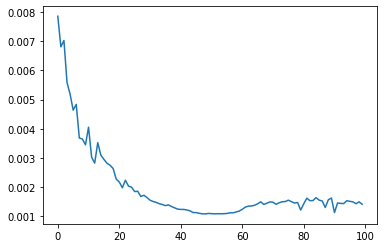

In [9]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt2=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    evalution_costplt2.append(evalution_cost)
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
plt.plot(evalution_costplt2)

## epoch : 100 , batchsize : 512 , timesize : 32
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10
# date_duration=3000

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  4.8309927058871835
evalution_cost :  0.5716920723207295
epoch : 0, t_cost : 0.046452, e_cost : 0.012993, elapsed time : 51.89sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  1.5614599350374192
evalution_cost :  0.40709672519005835
epoch : 1, t_cost : 0.015014, e_cost : 0.009252, elapsed time : 46.93sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.9510280813556165
evalution_cost :  0.3251543550286442
ep

data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.3024271781905554
evalution_cost :  0.07636156614171341
epoch : 25, t_cost : 0.002908, e_cost : 0.001735, elapsed time : 46.61sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.24309383728541434
evalution_cost :  0.06963073869701475
epoch : 26, t_cost : 0.002337, e_cost : 0.001583, elapsed time : 46.68sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.20956537476740777
evalution_cost :  0.06192055332940072
epoch : 27, t_cost : 0.002015, e_cost : 0.001407, elapsed time : 46.60sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (2301

data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.19004152051638812
evalution_cost :  0.058541583246551454
epoch : 51, t_cost : 0.001827, e_cost : 0.001330, elapsed time : 46.89sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.19643010810250416
evalution_cost :  0.05689824992441572
epoch : 52, t_cost : 0.001889, e_cost : 0.001293, elapsed time : 46.69sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.20246403286000714
evalution_cost :  0.05613224988337606
epoch : 53, t_cost : 0.001947, e_cost : 0.001276, elapsed time : 46.39sec
data1 :  (53690, 32, 1) (53

traning_cost :  0.18197437113849446
evalution_cost :  0.05550680254236795
epoch : 76, t_cost : 0.001750, e_cost : 0.001262, elapsed time : 46.69sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.18226331000914797
evalution_cost :  0.054433863260783255
epoch : 77, t_cost : 0.001753, e_cost : 0.001237, elapsed time : 48.08sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.1824517680797726
evalution_cost :  0.05607441277243197
epoch : 78, t_cost : 0.001754, e_cost : 0.001274, elapsed time : 47.48sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.1807687813

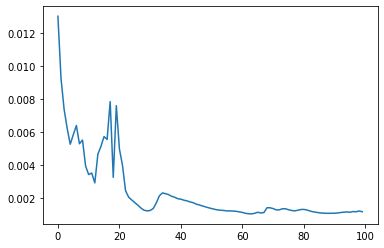

In [17]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt2=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    evalution_costplt2.append(evalution_cost)
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
plt.plot(evalution_costplt2)

## epoch : 100 , batchsize : 256 , timesize : 32
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10
# date_duration=3000

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	

#training#
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  7.0361625659279525
evalution_cost :  2.3805597964674234
epoch : 0, t_cost : 0.033666, e_cost : 0.026748, elapsed time : 56.32sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  2.895106978248805
evalution_cost :  1.9210706206504256
epoch : 1, t_cost : 0.013852, e_cost : 0.021585, elapsed time : 51.19sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  2.470947590423748
evalution_cost :  0.9846599128795788
epoch

data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.28524214439676143
evalution_cost :  0.10470184471341781
epoch : 25, t_cost : 0.001365, e_cost : 0.001176, elapsed time : 51.44sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.2879378225770779
evalution_cost :  0.09958251306670718
epoch : 26, t_cost : 0.001378, e_cost : 0.001119, elapsed time : 51.46sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.2896624252316542
evalution_cost :  0.09845329806557857
epoch : 27, t_cost : 0.001386, e_cost : 0.001106, elapsed time : 51.42sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010

data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.25601083420042414
evalution_cost :  0.1117481192923151
epoch : 51, t_cost : 0.001225, e_cost : 0.001256, elapsed time : 51.25sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.2552490250382107
evalution_cost :  0.1328077192301862
epoch : 52, t_cost : 0.001221, e_cost : 0.001492, elapsed time : 51.15sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.2521302271343302
evalution_cost :  0.14554980711545795
epoch : 53, t_cost : 0.001206, e_cost : 0.001635, elapsed time : 51.07sec
data1 :  (53690, 32, 1) (53690, 

traning_cost :  0.27032690215855837
evalution_cost :  0.11710303172003478
epoch : 76, t_cost : 0.001293, e_cost : 0.001316, elapsed time : 51.29sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.2614478645264171
evalution_cost :  0.10958913707872853
epoch : 77, t_cost : 0.001251, e_cost : 0.001231, elapsed time : 50.93sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.25525349064264446
evalution_cost :  0.1037942883267533
epoch : 78, t_cost : 0.001221, e_cost : 0.001166, elapsed time : 50.55sec
data1 :  (53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
data1 :  (23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
traning_cost :  0.258186859602

NameError: name 'mean' is not defined

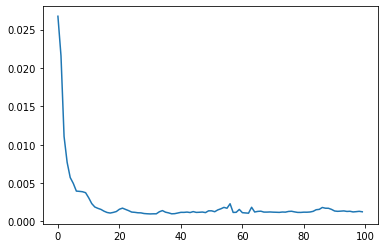

In [18]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt2=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    evalution_costplt2.append(evalution_cost)
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt2))

mean(evalution_costplt2)

## Data : nasdaq 

In [ ]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=40560
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>=self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


## eopch : 100 , batchsize : 512 , timesize : 32

In [ ]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt2=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    evalution_costplt2.append(evalution_cost)
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt2))

mean(evalution_costplt2)